In [155]:
# IMPORTER
import torch
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import *
from sklearn.compose import *
from jcopml.pipeline import *
from torch.utils.data import *
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy
from tqdm.auto import tqdm

device = 'mps'

In [156]:
# DATASET
df = pd.read_csv('diabetes.csv')
df.drop(columns='Insulin', inplace=True)
df.Outcome.value_counts()
X = df.drop(columns='Outcome')
y = df.Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((614, 7), (614,), (154, 7), (154,))

In [157]:
# PREPROCESSING
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [158]:
# DATASET & DATALOADER

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train.values).to(device)
y_test = torch.FloatTensor(y_test.values).to(device)

train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

In [159]:
# MODELLING

model = nn.Sequential(
    nn.Linear(7,16),
    nn.ReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(16,8),
    nn.ReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(4,2),
    nn.LogSoftmax(1),
).to(device)
model

Sequential(
  (0): Linear(in_features=7, out_features=16, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=16, out_features=8, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.25, inplace=False)
  (6): Linear(in_features=8, out_features=4, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.25, inplace=False)
  (9): Linear(in_features=4, out_features=2, bias=True)
  (10): LogSoftmax(dim=1)
)

In [160]:
# CRITERION

criterion = nn.NLLLoss()

In [161]:
# OPTIMIZER

optimizer = optim.AdamW(model.parameters())

In [162]:
# TRAINING VAL LOOP

epochs = 1000
train_loss, test_loss = [], []

for epoch in range(epochs):
    # TRAIN LOOP
    cost = 0
    model.train()
    for x, y in train_loader:
        # 1 feed forward
        y_pred = model(x)
        
        # 2 compute loss
        loss = criterion(y_pred, y)
        
        # 3 backpropagatiion
        loss.backward()
        
        # 3 update weight
        optimizer.step()
        
        # 4 reset optimizer
        optimizer.zero_grad()
        
        # 5 calculate cost
        cost += loss.item() * y.shape[0]
    train_loss.append(cost/len(train_set))
    # VAL LOOP
    cost = 0
    model.eval()
    for x, y in test_loader:
        # 1 feed forward
        y_pred = model(x)
        
        # 2 calculate loss
        loss = criterion(y_pred, y)
        
        # 3 calculate cost
        cost += loss.item()*x.shape[0]
    test_loss.append(cost/len(test_set))
    print(f"\rEpoch: {epoch+1:4}/{epochs:4} | train_loss: {train_loss[-1]:.4f} | val_loss: {test_loss[-1]:.4f}", end=" ")
        

Epoch: 1000/1000 | train_loss: 0.5273 | val_loss: 0.7379 

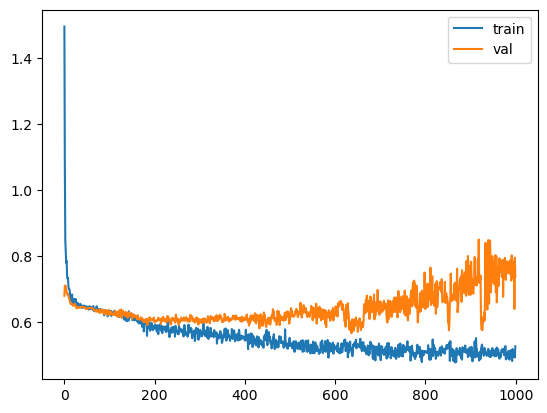

In [163]:
# PLOT LOSS
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.legend()

In [164]:
# CALCULATE ACCURACY
y_pred = model(X_test)
acc = Accuracy(task='multiclass', num_classes=2).to(device)
acc(y_pred, y_test)

tensor(0.6299, device='mps:0')

In [165]:
# SAVE MODEL
torch.save(model.state_dict(),'models/weights.pth')
log = {
    'train_loss': train_loss,
    'val_loss': test_loss,
}
torch.save(log, 'models/logs.pth')

In [166]:
# LOAD MODEL
weights = torch.load('models/weights.pth', map_location='cpu')
loaded_model = nn.Sequential(
    nn.Linear(7,16),
    nn.ReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(16,8),
    nn.ReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(4,2),
    nn.LogSoftmax(1),
)
loaded_model.load_state_dict(weights)
loaded_model.to(device)

Sequential(
  (0): Linear(in_features=7, out_features=16, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=16, out_features=8, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.25, inplace=False)
  (6): Linear(in_features=8, out_features=4, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.25, inplace=False)
  (9): Linear(in_features=4, out_features=2, bias=True)
  (10): LogSoftmax(dim=1)
)

In [167]:
# CALCULATE ACCURACY
loaded_model.eval()
y_pred = loaded_model(X_test)
acc = Accuracy(task='multiclass', num_classes=2).to(device)
acc(y_pred, y_test)

tensor(0.6299, device='mps:0')